## Import libraries

In [1]:
# !pip install tensorly

import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from tensorly.decomposition import tensor_train
from math import ceil
from tensorly import tt_to_tensor
from tensorly.decomposition import matrix_product_state
import torch.nn.init as init

In [2]:
"""
5 runs of 50 epochs, seed = 10, 20, 30, 40, 50;
validation accuracies: 0.9492, 0.9457, 0.9463, 0.9439, 0.9455
"""
#from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

dtype = torch.float64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version: 1.13.1
Torchvision Version: 0.14.1
GPU is available? True


## train data processing

In [3]:
df_train_1 = pd.read_csv('/home/c/cl237/Datasets/Flare_LSTM_dataset/M/normalized_training.csv')
df_train_2 = pd.read_csv('/home/c/cl237/Datasets/Flare_LSTM_dataset/M/normalized_validation.csv')
# concat train and validation into train. we don't need validation set
df_train = df_train_1.append(df_train_2).reset_index(drop=True)

# undersampling for "negative" samples
negative_df = df_train[df_train['label'] == 'Negative']
positive_df = df_train[df_train['label'] == 'Positive']

# Get number of "positive" samples
num_positive = len(positive_df)

# take the same number of "negative" samples as there are "positive" samples
balanced_negative_df = negative_df.sample(n=num_positive, random_state=10086)

df_train_balanced = pd.concat([positive_df, balanced_negative_df])
print(df_train_balanced['label'].value_counts())

Positive    4057
Negative    4057
Name: label, dtype: int64


In [4]:
pd_X_train = df_train_balanced.iloc[:, 5:]
pd_y_train = df_train_balanced.iloc[:, 0]

N = len(pd_X_train)
K = 2

pd_X_train = pd_X_train.values
X_train = torch.tensor(pd_X_train, dtype=dtype, device=device)
X_train = torch.t(X_train)

# scaler = MinMaxScaler()
# x = pd_X_train.values
# x_scaled = scaler.fit_transform(x)
# X_train = torch.tensor(x_scaled, dtype=dtype, device=device)
# X_train = torch.t(X_train)

# Initialize the LabelEncoder
encoder = LabelEncoder()
# Fit and transform the y values
y = encoder.fit_transform(pd_y_train.values)
y_train=torch.tensor(y, dtype=torch.long, device=device)
y_train = torch.flatten(y_train)

y_one_hot = torch.zeros(N, K, device=device).scatter_(1, y_train.unsqueeze(1), 1)
y_one_hot = torch.t(y_one_hot).to(device=device)

print(list(encoder.classes_))

['Negative', 'Positive']


## test data processing

In [5]:
df_test = pd.read_csv('/home/c/cl237/Datasets/Flare_LSTM_dataset/M/normalized_testing.csv')

# Undersampling for "negative" samples
#negative_df = df_test[df_test['label'] == 'Negative']
#positive_df = df_test[df_test['label'] == 'Positive']

# Get number of "positive" samples
#num_positive = len(positive_df)

# Take the same number of "negative" samples as there are "positive" samples
#balanced_negative_df = negative_df.sample(n=num_positive, random_state=10086)

#df_test_balanced = pd.concat([positive_df, balanced_negative_df])
#print(df_test_balanced['label'].value_counts())

In [6]:
pd_X_test = df_test.iloc[:, 5:]
pd_y_test = df_test.iloc[:, 0]

N_test = len(pd_X_test)
K = 2

pd_X_test = pd_X_test.values
X_test = torch.tensor(pd_X_test, dtype=dtype, device=device)
X_test = torch.t(X_test)
# x = pd_X_test.values
# x_scaled = scaler.transform(x)  # only transform x, don't fit the scaler again
# X_test = torch.tensor(x_scaled, dtype=dtype, device=device)
# X_test = torch.t(X_test)


# Initialize the LabelEncoder
encoder = LabelEncoder()
# Fit and transform the y values
y = encoder.fit_transform(pd_y_test.values)
y_test=torch.tensor(y, dtype=torch.long, device=device)
y_test = torch.flatten(y_test)

y_test_one_hot = torch.zeros(N_test, K, device=device).scatter_(1, y_test.unsqueeze(1), 1)
y_test_one_hot = torch.t(y_test_one_hot).to(device=device)

In [7]:
print(df_test['label'].value_counts())

Negative    43411
Positive     1278
Name: label, dtype: int64


## Main algorithm

### Define functions for updating blocks

In [8]:
# def updateMask(W, sparsity):
#     torch.dist(V1,nn.ReLU()(U1),2),2).cpu().numpy()
#     Mask
#     Wsparse
#     return Mask, Wsparse

# Wsquare = torch.square(W3)
# Threshold = torch.quantile(torch.reshape(Wsquare, (-1,)), 0.5, interpolation='linear')
# Wsparse = W3
# Wsparse[Wsquare < Threshold] =  0

# Wsparse

In [9]:
def updateV(U1,U2,W,b,rho,gamma):
    _, d = W.size()
    I = torch.eye(d, device=device)
    U1 = nn.ReLU()(U1)
    _, col_U2 = U2.size()
    Vstar = torch.mm(torch.inverse(rho*(torch.mm(torch.t(W),W))+gamma*I), rho*torch.mm(torch.t(W),U2-b.repeat(1,col_U2))+gamma*U1)
    return Vstar

In [10]:
def updateWb_org(U, V, W, b, alpha, rho):
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse(alpha*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = 0*(alpha*b+rho*torch.sum(U-torch.mm(Wstar,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

In [11]:
def updateWb(U, V, W, b, W_tensor_rec, alpha, rho,tau):
    W_tensor_rec = torch.as_tensor(W_tensor_rec,device=device).float()
    W_tensor2matrix = W_tensor_rec.reshape(W.shape)
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+tau*W_tensor2matrix+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse((alpha+tau)*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = 0*(alpha*b+rho*torch.sum(U-torch.mm(Wstar,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

In [12]:
def updateWbsparse(U, V, W, b,  W_tensor2matrix, alpha, rho,tau):
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+tau*W_tensor2matrix+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse((alpha+tau)*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = 0*(alpha*b+rho*torch.sum(U-torch.mm(Wstar,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

### Define the proximal operator of the ReLU activation function

In [13]:
def relu_prox(a, b, gamma, d, N):
    val = torch.empty(d,N, device=device)
    x = (a+gamma*b)/(1+gamma)
    y = torch.min(b,torch.zeros(d,N, device=device))

    val = torch.where(a+gamma*b < 0, y, torch.zeros(d,N, device=device))
    val = torch.where(((a+gamma*b >= 0) & (b >=0)) | ((a*(gamma-np.sqrt(gamma*(gamma+1))) <= gamma*b) & (b < 0)), x, val)
    val = torch.where((-a <= gamma*b) & (gamma*b <= a*(gamma-np.sqrt(gamma*(gamma+1)))), b, val)
    return val

### Effective Sparsity

In [14]:
def process_weights(W1, W2, W3):
    # Clone the tensors to keep the originals unchanged
    W1, W2, W3 = W1.clone(), W2.clone(), W3.clone()

    while True:
        # Store a copy of the current weights
        old_W1, old_W2, old_W3 = W1.clone(), W2.clone(), W3.clone()

        # Check all rows of W1
        # If all values in a row of W1 are 0, set corresponding column in W2 to 0
        zero_rows_W1 = torch.all(W1 == 0, dim=1)
        W2[:, zero_rows_W1] = 0

        # Check all columns of W2
        # If all values in a column of W2 are 0, set corresponding row in W1 to 0
        zero_cols_W2 = torch.all(W2 == 0, dim=0)
        W1[zero_cols_W2, :] = 0

        # Check all rows of W2
        # If all values in a row of W2 are 0, set corresponding column in W3 to 0
        zero_rows_W2 = torch.all(W2 == 0, dim=1)
        W3[:, zero_rows_W2] = 0

        # Check if matrices are unchanged
        if torch.equal(W1, old_W1) and torch.equal(W2, old_W2) and torch.equal(W3, old_W3):
            break

    return W1, W2, W3

### Parameter initialization

In [17]:
#df = pd.DataFrame()
#df.to_csv('/home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/differernt gamma rho/result.csv')

niter = 1000
sparsity = 0.9

tau = 200
alpha = 1
rho = 1
gamma = 100

        

# Do something with these parameters
print(sparsity, tau, gamma, rho, alpha)

loss1 = np.empty(niter)
loss2 = np.empty(niter)
accuracy_train = np.empty(niter)
accuracy_test = np.empty(niter)
time1 = np.empty(niter)
bacc_train = np.empty(niter)
bacc_test = np.empty(niter)
true_sparsity = np.empty(niter)
effective_sparsity = np.empty(niter)

results = torch.zeros(1, 9, niter)

for Out_iter in range(1):
    rank_initial = 700
    seed = 10 + 10*Out_iter
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)

    d0 = 40
    d1 =  300
    d2 =  100
    d3 = K # Layers: input + 2 hidden + output

    W1 = 0.25*init.kaiming_uniform_(torch.empty(d1, d0, device=device, dtype=dtype),a=0, mode='fan_in', nonlinearity='leaky_relu')
    b1 = 0*torch.ones(d1, 1, dtype=torch.float64,device=device)
    W1square = torch.square(W1)
    Threshold = torch.quantile(torch.reshape(W1square, (-1,)), sparsity, interpolation='linear')
    W1sparse = W1
    W1sparse[W1square < Threshold] =  0

    W2 = 0.25*init.kaiming_uniform_(torch.empty(d2, d1, device=device, dtype=dtype),a=0, mode='fan_in', nonlinearity='leaky_relu')
    b2 = 0*torch.ones(d2, 1, dtype=torch.float64,device=device)
    W2square = torch.square(W2)
    Threshold = torch.quantile(torch.reshape(W2square, (-1,)), sparsity, interpolation='linear')
    W2sparse = W2
    W2sparse[W2square < Threshold] =  0


    W3 = 0.25*init.kaiming_uniform_(torch.empty(d3, d2, device=device, dtype=dtype),a=0, mode='fan_in', nonlinearity='leaky_relu')
    b3 = 0*torch.ones(d3, 1, dtype=torch.float64,device=device)
    # W3square = torch.square(W3)
    # Threshold = torch.quantile(torch.reshape(W3square, (-1,)), sparsity, interpolation='linear')
    # W3sparse = W3
    # W3sparse[W3square < Threshold] =  0


    U1 = torch.addmm(b1.repeat(1, N), W1, X_train)
    V1 = nn.ReLU()(U1)
    U2 = torch.addmm(b2.repeat(1, N), W2, V1)
    V2 = nn.ReLU()(U2)
    U3 = torch.addmm(b3.repeat(1, N), W3, V2)
    V3 = U3
    # U4 = torch.addmm(b4.repeat(1, N), W4, V3)
    # V4 = U4


    print('Train on', N, 'samples, validate on', N_test, 'samples')

    for k in range(niter):

        start = time.time()

        # update V4
        V3 = (y_one_hot + gamma*U3 + alpha*V3)/(1 + gamma + alpha)

        # update U4
        U3 = (gamma*V3 + rho*(torch.mm(W3,V2) + b3.repeat(1,N)))/(gamma + rho)

        # update W4 and b4
        W3, b3 = updateWb_org(U3,V2,W3,b3, alpha,rho)
        # W3square = torch.square(W3)
        # Threshold = torch.quantile(torch.reshape(W3square, (-1,)), sparsity, interpolation='linear')
        # W3sparse = W3
        # W3sparse[W3square < Threshold] =  0
        # update V2
        V2 = updateV(U2,U3,W3,b3,rho,gamma)

        # update U2
        U2 = relu_prox(V2,(rho*torch.addmm(b2.repeat(1,N), W2, V1) + alpha*U2)/(rho + alpha),(rho + alpha)/gamma,d2,N)

        # update W2 and b2

        W2, b2 = updateWbsparse(U2,V1,W2,b2,W2sparse, alpha,rho,tau)
        W2square = torch.square(W2)
        Threshold = torch.quantile(torch.reshape(W2square, (-1,)), sparsity, interpolation='linear')
        W2sparse = W2
        W2sparse[W2square < Threshold] =  0

        # update V1
        V1 = updateV(U1,U2,W2,b2,rho,gamma)

        # update U1
        U1 = relu_prox(V1,(rho*torch.addmm(b1.repeat(1,N), W1, X_train) + alpha*U1)/(rho + alpha),(rho + alpha)/gamma,d1,N)

        # update W1 and b1
        W1, b1 = updateWbsparse(U1,X_train,W1,b1,W1sparse, alpha,rho,tau)
        W1square = torch.square(W1)
        Threshold = torch.quantile(torch.reshape(W1square, (-1,)), sparsity, interpolation='linear')
        W1sparse = W1
        W1sparse[W1square < Threshold] =  0

        a1_train = nn.ReLU()(torch.addmm(b1.repeat(1, N), W1sparse, X_train)).double()
        a2_train = nn.ReLU()(torch.addmm(b2.repeat(1, N),  W2sparse, a1_train)).double()
        pred = torch.argmax(torch.addmm(b3.repeat(1, N), W3, a2_train), dim=0)

        a1_test = nn.ReLU()(torch.addmm(b1.repeat(1, N_test), W1sparse, X_test)).double()
        a2_test = nn.ReLU()(torch.addmm(b2.repeat(1, N_test),  W2sparse, a1_test)).double()
        pred_test = torch.argmax(torch.addmm(b3.repeat(1, N_test), W3, a2_test), dim=0)


        loss1[k] = gamma/2*torch.pow(torch.dist(V3,y_one_hot,2),2).cpu().numpy()
        loss2[k] = loss1[k] + rho/2*torch.pow(torch.dist(torch.addmm(b1.repeat(1,N), W1sparse, X_train),U1,2),2).cpu().numpy() \
        +rho/2*torch.pow(torch.dist(torch.addmm(b2.repeat(1,N),  W2sparse, V1),U2,2),2).cpu().numpy() \
        +rho/2*torch.pow(torch.dist(torch.addmm(b3.repeat(1,N), W3, V2),U3,2),2).cpu().numpy() \
        + gamma/2*torch.pow(torch.dist(V1,nn.ReLU()(U1),2),2).cpu().numpy() \
        + gamma/2*torch.pow(torch.dist(V2,nn.ReLU()(U2),2),2).cpu().numpy() \
        + gamma/2*torch.pow(torch.dist(V3,U3,2),2).cpu().numpy() \
        + tau/2*torch.pow(torch.dist(W1,W1sparse,2),2).cpu().numpy()\
        + tau/2*torch.pow(torch.dist(W2,W2sparse,2),2).cpu().numpy()\
        # + tau/2*torch.pow(torch.dist(W3,W3sparse,2),2).cpu().numpy()

        # compute training accuracy
        correct_train = pred == y_train
        accuracy_train[k] = np.mean(correct_train.cpu().numpy())

        # compute validation accuracy
        correct_test = pred_test == y_test
        accuracy_test[k] = np.mean(correct_test.cpu().numpy())


        pred_train_np = pred.cpu().numpy()
        y_train_np = y_train.cpu().numpy()
        pred_test_np = pred_test.cpu().numpy()
        y_test_np = y_test.cpu().numpy()

        bacc_train[k] = balanced_accuracy_score(y_train_np, pred_train_np)
        bacc_test[k] = balanced_accuracy_score(y_test_np, pred_test_np)

        # compute training time
        stop = time.time()
        duration = stop - start
        time1[k] = duration

        # sparsity
        num_zeros_W1 = torch.sum(W1 == 0).item()
        num_zeros_W2 = torch.sum(W2 == 0).item()
        num_zeros_W3 = torch.sum(W3 == 0).item()
        total_zeros_old = num_zeros_W1 + num_zeros_W2 + num_zeros_W3
        total_weights = d0*d1+d1*d2+d2*d3
        true_sparsity[k] = total_zeros_old / total_weights

        new_W1, new_W2, new_W3 = process_weights(W1, W2, W3)
        num_zeros_W1_new = torch.sum(new_W1 == 0).item()
        num_zeros_W2_new = torch.sum(new_W2 == 0).item()
        num_zeros_W3_new = torch.sum(new_W3 == 0).item()
        total_zeros = num_zeros_W1_new + num_zeros_W2_new + num_zeros_W3_new
        total_weights = d0*d1+d1*d2+d2*d3
        effective_sparsity[k] = total_zeros / total_weights


        # print results
        print('Epoch', k + 1, '/', niter, '\n',
              '-', 'time:', time1[k], '-', 'sq_loss:', loss1[k], '-', 'tot_loss:', loss2[k],
              '-', 'acc:', accuracy_train[k], '-', 'val_acc:', accuracy_test[k],
              '-', 'bacc_train:', bacc_train[k], '-', 'bacc_test:', bacc_test[k],'-', 'true_sparsity:', true_sparsity[k],
             '-', 'effective_sparsity:', effective_sparsity[k])


    results[Out_iter,0,:] = torch.tensor(loss1)
    results[Out_iter,1,:] = torch.tensor(loss2)
    results[Out_iter,2,:] = torch.tensor(accuracy_train)
    results[Out_iter,3,:] = torch.tensor(accuracy_test)
    results[Out_iter,4,:] = torch.tensor(time1)
    results[Out_iter,5,:] = torch.tensor(bacc_train)
    results[Out_iter,6,:] = torch.tensor(bacc_test)
    results[Out_iter,7,:] = torch.tensor(true_sparsity)
    results[Out_iter,8,:] = torch.tensor(effective_sparsity)

#             df=pd.read_csv('/home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/differernt gamma rho/result.csv')
#             new_row = {
#                         'tau': tau, 
#                         'gamma': gamma, 
#                         'rho': rho, 
#                         'alpha': alpha,
#                         'loss1': loss1[niter-1], 
#                         'loss2': loss2[niter-1], 
#                         'accuracy_train': accuracy_train[niter-1],
#                         'accuracy_test': accuracy_test[niter-1], 
#                         'max_accuracy_train': max(accuracy_train),
#                         'max_accuracy_test': max(accuracy_test),
#                         'time': time1[niter-1], 
#                         'BACC_train': bacc_train[niter-1],
#                         'BACC_test': bacc_test[niter-1],
#                         'max_BACC_train': max(bacc_train),
#                         'max_BACC_test': max(bacc_test),
#                         'Sparsity': sparsity,
#                         'seed' : seed
#                     }

#             df=df.append(new_row,ignore_index=True)
#             df.to_csv('/home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/differernt gamma rho/result.csv',index=False)

filename="KaimingUniform_" + "niter_"+ str(niter) + "Sparsity_" + str(sparsity) +"tau_" + str(tau) + "gamma_" + str(gamma) + \
                "rho_" + str(rho) + "alpha_" + str(alpha)+ ".mat"
from scipy.io import savemat
%cd /home/c/cl237/TenBCD/Sparse/LeNet300_100/Flare(BCD method)/different init/
savemat (filename, {'results': torch.Tensor.numpy(results)})

0.9 200 100 1 1
Train on 8114 samples, validate on 44689 samples
Epoch 1 / 1000 
 - time: 0.02901315689086914 - sq_loss: 391869.823458546 - tot_loss: 391869.9354630451 - acc: 0.7867882671925068 - val_acc: 0.8092147955872809 - bacc_train: 0.7867882671925068 - bacc_test: 0.8307917258013797 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 2 / 1000 
 - time: 0.028226375579833984 - sq_loss: 384298.3551140888 - tot_loss: 384298.7630186528 - acc: 0.8214197683017007 - val_acc: 0.8531182170108975 - bacc_train: 0.8214197683017008 - bacc_test: 0.8663001134586191 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 3 / 1000 
 - time: 0.028107881546020508 - sq_loss: 376898.2017887996 - tot_loss: 376899.0649178147 - acc: 0.8296771013063841 - val_acc: 0.8615319206068608 - bacc_train: 0.829677101306384 - bacc_test: 0.8744279979375356 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 4 / 1000 
 - time: 0.02

Epoch 31 / 1000 
 - time: 0.026891231536865234 - sq_loss: 219310.71654244533 - tot_loss: 219311.41786287582 - acc: 0.8544491003204339 - val_acc: 0.8736378079616908 - bacc_train: 0.8544491003204338 - bacc_test: 0.8650906794752014 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 32 / 1000 
 - time: 0.02756500244140625 - sq_loss: 215082.3652002368 - tot_loss: 215083.0681868103 - acc: 0.8542026127680552 - val_acc: 0.8736378079616908 - bacc_train: 0.8542026127680552 - bacc_test: 0.8658501164525307 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 33 / 1000 
 - time: 0.02695178985595703 - sq_loss: 210935.24105084685 - tot_loss: 210935.94697690924 - acc: 0.8542026127680552 - val_acc: 0.8735259236053615 - bacc_train: 0.8542026127680552 - bacc_test: 0.8665519643395374 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 34 / 1000 
 - time: 0.026860475540161133 - sq_loss: 206867.8208263359 - tot_loss

Epoch 63 / 1000 
 - time: 0.02690267562866211 - sq_loss: 117585.18860554669 - tot_loss: 117586.07594111358 - acc: 0.8535863938871087 - val_acc: 0.8737049385754884 - bacc_train: 0.8535863938871087 - bacc_test: 0.8715804472366953 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 64 / 1000 
 - time: 0.02687239646911621 - sq_loss: 115316.30578591042 - tot_loss: 115317.20317560596 - acc: 0.8538328814394873 - val_acc: 0.8736825617042225 - bacc_train: 0.8538328814394873 - bacc_test: 0.8715689294186306 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 65 / 1000 
 - time: 0.02682805061340332 - sq_loss: 113091.18624202225 - tot_loss: 113092.09528035908 - acc: 0.8539561252156767 - val_acc: 0.8737049385754884 - bacc_train: 0.8539561252156767 - bacc_test: 0.8715804472366953 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 66 / 1000 
 - time: 0.026839017868041992 - sq_loss: 110908.98700512601 - tot_lo

Epoch 95 / 1000 
 - time: 0.026885032653808594 - sq_loss: 63031.034688687665 - tot_loss: 63069.97093029569 - acc: 0.855311806753759 - val_acc: 0.8763006556423281 - bacc_train: 0.8553118067537588 - bacc_test: 0.8740556695981767 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 96 / 1000 
 - time: 0.026900053024291992 - sq_loss: 61814.70386526917 - tot_loss: 61851.99406407406 - acc: 0.855311806753759 - val_acc: 0.8762559018997964 - bacc_train: 0.8553118067537588 - bacc_test: 0.8740326339620477 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 97 / 1000 
 - time: 0.02687239646911621 - sq_loss: 60621.8459807838 - tot_loss: 60653.634390593485 - acc: 0.855311806753759 - val_acc: 0.8763677862561257 - bacc_train: 0.8553118067537588 - bacc_test: 0.8744699415410351 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 98 / 1000 
 - time: 0.026790380477905273 - sq_loss: 59452.00840430184 - tot_loss: 594

Epoch 127 / 1000 
 - time: 0.02689051628112793 - sq_loss: 33787.80167187445 - tot_loss: 33792.32602137426 - acc: 0.8566674882918413 - val_acc: 0.8774194992056211 - bacc_train: 0.8566674882918413 - bacc_test: 0.8765301529447276 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 128 / 1000 
 - time: 0.027086973190307617 - sq_loss: 33135.84991046424 - tot_loss: 33140.23470384871 - acc: 0.8566674882918413 - val_acc: 0.8774642529481528 - bacc_train: 0.8566674882918413 - bacc_test: 0.8765531885808566 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 129 / 1000 
 - time: 0.02698349952697754 - sq_loss: 32496.480820746852 - tot_loss: 32500.778182692302 - acc: 0.8566674882918413 - val_acc: 0.8775313835619504 - bacc_train: 0.8566674882918413 - bacc_test: 0.8765877420350503 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 130 / 1000 
 - time: 0.026976346969604492 - sq_loss: 31869.451755512284 - tot_l

Epoch 159 / 1000 
 - time: 0.0281827449798584 - sq_loss: 18113.655243480796 - tot_loss: 18124.597085103174 - acc: 0.8567907320680306 - val_acc: 0.8784488352838506 - bacc_train: 0.8567907320680306 - bacc_test: 0.8774396910643614 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 160 / 1000 
 - time: 0.02689218521118164 - sq_loss: 17764.21412734785 - tot_loss: 17775.845114893287 - acc: 0.8569139758442199 - val_acc: 0.8784488352838506 - bacc_train: 0.8569139758442199 - bacc_test: 0.8774396910643614 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 161 / 1000 
 - time: 0.02710556983947754 - sq_loss: 17421.516876510213 - tot_loss: 17433.516892567503 - acc: 0.8570372196204091 - val_acc: 0.8784935890263823 - bacc_train: 0.8570372196204092 - bacc_test: 0.8778424451891552 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 162 / 1000 
 - time: 0.026888370513916016 - sq_loss: 17085.433547451124 - tot_

Epoch 191 / 1000 
 - time: 0.026862382888793945 - sq_loss: 9712.280442771444 - tot_loss: 9724.445652762004 - acc: 0.857776682277545 - val_acc: 0.8783145740562555 - bacc_train: 0.857776682277545 - bacc_test: 0.8777503026446388 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 192 / 1000 
 - time: 0.026947498321533203 - sq_loss: 9524.97312843436 - tot_loss: 9537.331364256346 - acc: 0.857776682277545 - val_acc: 0.878381704670053 - bacc_train: 0.857776682277545 - bacc_test: 0.8777848560988324 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 193 / 1000 
 - time: 0.026851415634155273 - sq_loss: 9341.280188874262 - tot_loss: 9353.84039891589 - acc: 0.857776682277545 - val_acc: 0.8784712121551165 - bacc_train: 0.857776682277545 - bacc_test: 0.8778309273710907 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 194 / 1000 
 - time: 0.026844024658203125 - sq_loss: 9161.131761838727 - tot_loss: 9173.

Epoch 223 / 1000 
 - time: 0.026951074600219727 - sq_loss: 5208.786175258982 - tot_loss: 5230.445604462409 - acc: 0.8585161449346808 - val_acc: 0.8799480856586632 - bacc_train: 0.8585161449346808 - bacc_test: 0.8770722294086918 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 224 / 1000 
 - time: 0.02687239646911621 - sq_loss: 5108.374436836818 - tot_loss: 5130.668441045945 - acc: 0.8583929011584915 - val_acc: 0.8800599700149925 - bacc_train: 0.8583929011584914 - bacc_test: 0.8767501000103498 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 225 / 1000 
 - time: 0.027022361755371094 - sq_loss: 5009.8999621093835 - tot_loss: 5033.474732934142 - acc: 0.8586393887108701 - val_acc: 0.8801271006287901 - bacc_train: 0.8586393887108701 - bacc_test: 0.8767846534645434 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 226 / 1000 
 - time: 0.026947021484375 - sq_loss: 4913.325354993312 - tot_loss:

Epoch 255 / 1000 
 - time: 0.027051448822021484 - sq_loss: 2794.40779360566 - tot_loss: 2863.2723327495314 - acc: 0.8592556075918166 - val_acc: 0.8808431605092976 - bacc_train: 0.8592556075918165 - bacc_test: 0.8756343496879501 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 256 / 1000 
 - time: 0.026887178421020508 - sq_loss: 2740.571299512086 - tot_loss: 2818.872825625584 - acc: 0.8595020951441952 - val_acc: 0.8824766721117053 - bacc_train: 0.8595020951441952 - bacc_test: 0.8726779655200148 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 257 / 1000 
 - time: 0.02702617645263672 - sq_loss: 2687.7731616253513 - tot_loss: 2747.134177836918 - acc: 0.8595020951441952 - val_acc: 0.8825438027255029 - bacc_train: 0.8595020951441952 - bacc_test: 0.8746111114175319 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 258 / 1000 
 - time: 0.0271451473236084 - sq_loss: 2635.993427010414 - tot_loss

Epoch 287 / 1000 
 - time: 0.026922225952148438 - sq_loss: 1499.8098215260886 - tot_loss: 1553.0491919894957 - acc: 0.8609810204584668 - val_acc: 0.883013717022086 - bacc_train: 0.8609810204584668 - bacc_test: 0.8752327040855521 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 288 / 1000 
 - time: 0.026892662048339844 - sq_loss: 1470.9390167636075 - tot_loss: 1524.6568983355246 - acc: 0.8607345329060883 - val_acc: 0.8829689632795542 - bacc_train: 0.8607345329060883 - bacc_test: 0.8755893869380877 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 289 / 1000 
 - time: 0.026874303817749023 - sq_loss: 1442.624802679872 - tot_loss: 1496.8924984434466 - acc: 0.8608577766822776 - val_acc: 0.8829242095370226 - bacc_train: 0.8608577766822776 - bacc_test: 0.8755663513019587 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 290 / 1000 
 - time: 0.02689957618713379 - sq_loss: 1414.8565227116196 - to

Epoch 319 / 1000 
 - time: 0.026839017868041992 - sq_loss: 805.4716379491333 - tot_loss: 870.1044222525094 - acc: 0.8611042642346561 - val_acc: 0.8815368435185392 - bacc_train: 0.8611042642346561 - bacc_test: 0.8752319650706215 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 320 / 1000 
 - time: 0.02688908576965332 - sq_loss: 789.9842610910941 - tot_loss: 854.8711587356783 - acc: 0.8611042642346561 - val_acc: 0.8815144666472734 - bacc_train: 0.8611042642346561 - bacc_test: 0.875220447252557 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 321 / 1000 
 - time: 0.026902437210083008 - sq_loss: 774.7953220977729 - tot_loss: 839.7600661162808 - acc: 0.8609810204584668 - val_acc: 0.8814697129047416 - bacc_train: 0.8609810204584668 - bacc_test: 0.8751974116164278 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 322 / 1000 
 - time: 0.026944398880004883 - sq_loss: 759.8990306865584 - tot_loss

Epoch 351 / 1000 
 - time: 0.026967763900756836 - sq_loss: 432.93393824530744 - tot_loss: 511.95799490502515 - acc: 0.8615972393394133 - val_acc: 0.8818053659737296 - bacc_train: 0.8615972393394133 - bacc_test: 0.8772687713307197 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 352 / 1000 
 - time: 0.02697300910949707 - sq_loss: 424.6220885192975 - tot_loss: 501.1430405303973 - acc: 0.8617204831156027 - val_acc: 0.8817829891024637 - bacc_train: 0.8617204831156027 - bacc_test: 0.8768775350239904 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 353 / 1000 
 - time: 0.026925325393676758 - sq_loss: 416.47026839170434 - tot_loss: 491.0328192351443 - acc: 0.8615972393394133 - val_acc: 0.8817158584886661 - bacc_train: 0.8615972393394133 - bacc_test: 0.876463263081132 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 354 / 1000 
 - time: 0.026930809020996094 - sq_loss: 408.47537566469657 - tot_

Epoch 383 / 1000 
 - time: 0.02693939208984375 - sq_loss: 232.95137189004245 - tot_loss: 272.8721960720842 - acc: 0.8625831895489278 - val_acc: 0.881268321063349 - bacc_train: 0.8625831895489278 - bacc_test: 0.8743343142765175 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 384 / 1000 
 - time: 0.026949405670166016 - sq_loss: 228.48810715223715 - tot_loss: 267.93829213989267 - acc: 0.8628296771013064 - val_acc: 0.8813578285484124 - bacc_train: 0.8628296771013064 - bacc_test: 0.8743803855487757 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 385 / 1000 
 - time: 0.02686309814453125 - sq_loss: 224.11070966518872 - tot_loss: 263.10368740578633 - acc: 0.8628296771013064 - val_acc: 0.8813578285484124 - bacc_train: 0.8628296771013064 - bacc_test: 0.8743803855487757 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 386 / 1000 
 - time: 0.027237892150878906 - sq_loss: 219.81752401900144 - tot

Epoch 415 / 1000 
 - time: 0.026999711990356445 - sq_loss: 125.5354004670731 - tot_loss: 161.88503285831123 - acc: 0.8633226522060636 - val_acc: 0.8822752802703127 - bacc_train: 0.8633226522060636 - bacc_test: 0.8756120530667515 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 416 / 1000 
 - time: 0.02686166763305664 - sq_loss: 123.13697345271402 - tot_loss: 159.93340653729763 - acc: 0.8633226522060636 - val_acc: 0.8822529033990467 - bacc_train: 0.8633226522060636 - bacc_test: 0.875600535248687 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 417 / 1000 
 - time: 0.026952266693115234 - sq_loss: 120.78461238141813 - tot_loss: 170.0821411799171 - acc: 0.8635691397584422 - val_acc: 0.8829465864082884 - bacc_train: 0.8635691397584422 - bacc_test: 0.8759575876086879 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 418 / 1000 
 - time: 0.027251005172729492 - sq_loss: 118.4774320441942 - tot_

Epoch 447 / 1000 
 - time: 0.02690744400024414 - sq_loss: 67.7873177866284 - tot_loss: 152.7422418026605 - acc: 0.8646783337441459 - val_acc: 0.8839982993577838 - bacc_train: 0.8646783337441459 - bacc_test: 0.8764989250577215 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 448 / 1000 
 - time: 0.026989459991455078 - sq_loss: 66.49709050823556 - tot_loss: 152.32035923761168 - acc: 0.8645550899679566 - val_acc: 0.8840206762290497 - bacc_train: 0.8645550899679566 - bacc_test: 0.8765104428757862 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 449 / 1000 
 - time: 0.02692127227783203 - sq_loss: 65.2315912814542 - tot_loss: 152.03412555342499 - acc: 0.8644318461917673 - val_acc: 0.8840206762290497 - bacc_train: 0.8644318461917673 - bacc_test: 0.8765104428757862 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 450 / 1000 
 - time: 0.026890993118286133 - sq_loss: 63.99035265851427 - tot_loss

Epoch 479 / 1000 
 - time: 0.0276186466217041 - sq_loss: 36.706479609850945 - tot_loss: 101.71490101062723 - acc: 0.8656642839536604 - val_acc: 0.8833493700910738 - bacc_train: 0.8656642839536604 - bacc_test: 0.8742663158905262 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 480 / 1000 
 - time: 0.026859045028686523 - sq_loss: 36.01162543207389 - tot_loss: 101.23862207773153 - acc: 0.8652945526250925 - val_acc: 0.8833493700910738 - bacc_train: 0.8652945526250924 - bacc_test: 0.8746460343791909 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 481 / 1000 
 - time: 0.027088642120361328 - sq_loss: 35.3300612295203 - tot_loss: 101.6582764085955 - acc: 0.8651713088489031 - val_acc: 0.8833493700910738 - bacc_train: 0.8651713088489031 - bacc_test: 0.8746460343791909 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 482 / 1000 
 - time: 0.026881933212280273 - sq_loss: 34.66154190851728 - tot_lo

Epoch 511 / 1000 
 - time: 0.02770686149597168 - sq_loss: 19.959115960245732 - tot_loss: 93.87449825705072 - acc: 0.8656642839536604 - val_acc: 0.8837969075163911 - bacc_train: 0.8656642839536604 - bacc_test: 0.8737372352744877 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 512 / 1000 
 - time: 0.02685236930847168 - sq_loss: 19.58438387814004 - tot_loss: 93.21934699327605 - acc: 0.8656642839536604 - val_acc: 0.8838192843876569 - bacc_train: 0.8656642839536604 - bacc_test: 0.8737487530925522 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 513 / 1000 
 - time: 0.026937246322631836 - sq_loss: 19.216793545293612 - tot_loss: 92.575151719049 - acc: 0.8659107715060389 - val_acc: 0.8839087918727203 - bacc_train: 0.865910771506039 - bacc_test: 0.8737948243648104 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 514 / 1000 
 - time: 0.02713918685913086 - sq_loss: 18.856213463986336 - tot_loss:

Epoch 543 / 1000 
 - time: 0.026940107345581055 - sq_loss: 10.917369683427253 - tot_loss: 75.79623019073759 - acc: 0.867143209267932 - val_acc: 0.885229027277406 - bacc_train: 0.867143209267932 - bacc_test: 0.8729555016759597 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 544 / 1000 
 - time: 0.027069568634033203 - sq_loss: 10.714714613157721 - tot_loss: 75.326286810451 - acc: 0.867143209267932 - val_acc: 0.885251404148672 - bacc_train: 0.867143209267932 - bacc_test: 0.8729670194940242 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 545 / 1000 
 - time: 0.02705526351928711 - sq_loss: 10.515906144478897 - tot_loss: 74.94664078508784 - acc: 0.8668967217155533 - val_acc: 0.8852961578912036 - bacc_train: 0.8668967217155534 - bacc_test: 0.8729900551301533 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 546 / 1000 
 - time: 0.026937484741210938 - sq_loss: 10.32086494873667 - tot_loss: 74

Epoch 575 / 1000 
 - time: 0.027219533920288086 - sq_loss: 6.019227846086265 - tot_loss: 69.5472747420968 - acc: 0.8664037466107961 - val_acc: 0.8843563292980375 - bacc_train: 0.8664037466107961 - bacc_test: 0.8744048992147659 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 576 / 1000 
 - time: 0.02688288688659668 - sq_loss: 5.909094357727021 - tot_loss: 69.55962713856665 - acc: 0.8664037466107961 - val_acc: 0.8843563292980375 - bacc_train: 0.8664037466107961 - bacc_test: 0.8744048992147659 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 577 / 1000 
 - time: 0.026815414428710938 - sq_loss: 5.801022985731186 - tot_loss: 69.62836678305909 - acc: 0.8664037466107961 - val_acc: 0.8844010830405693 - bacc_train: 0.8664037466107961 - bacc_test: 0.8744279348508951 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 578 / 1000 
 - time: 0.026854276657104492 - sq_loss: 5.694976910349188 - tot_loss

Epoch 607 / 1000 
 - time: 0.026862144470214844 - sq_loss: 3.351306486367986 - tot_loss: 42.65281811767476 - acc: 0.8672664530441213 - val_acc: 0.8840878068428473 - bacc_train: 0.8672664530441212 - bacc_test: 0.8742666853979915 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 608 / 1000 
 - time: 0.026860952377319336 - sq_loss: 3.29121031742801 - tot_loss: 42.217368795056366 - acc: 0.8672664530441213 - val_acc: 0.8840654299715813 - bacc_train: 0.8672664530441212 - bacc_test: 0.8742551675799269 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 609 / 1000 
 - time: 0.026819944381713867 - sq_loss: 3.232238783509699 - tot_loss: 41.74567752512797 - acc: 0.8672664530441213 - val_acc: 0.8840878068428473 - bacc_train: 0.8672664530441213 - bacc_test: 0.8742666853979915 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 610 / 1000 
 - time: 0.026845455169677734 - sq_loss: 3.1743735115922553 - tot_l

Epoch 639 / 1000 
 - time: 0.0269010066986084 - sq_loss: 1.8936896228832563 - tot_loss: 30.793469073467808 - acc: 0.8678826719250677 - val_acc: 0.885094766049811 - bacc_train: 0.8678826719250679 - bacc_test: 0.874784987210896 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 640 / 1000 
 - time: 0.027032136917114258 - sq_loss: 1.8607504049224146 - tot_loss: 30.467144142290582 - acc: 0.8678826719250677 - val_acc: 0.8851842735348744 - bacc_train: 0.8678826719250679 - bacc_test: 0.8748310584831542 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 641 / 1000 
 - time: 0.026998519897460938 - sq_loss: 1.8284176481936338 - tot_loss: 30.170528394932877 - acc: 0.8677594281488785 - val_acc: 0.8852961578912036 - bacc_train: 0.8677594281488785 - bacc_test: 0.874888647573477 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 642 / 1000 
 - time: 0.026970624923706055 - sq_loss: 1.7966782124290648 - tot_

Epoch 671 / 1000 
 - time: 0.027363300323486328 - sq_loss: 1.0915213662177692 - tot_loss: 22.601340782458703 - acc: 0.868375647029825 - val_acc: 0.8858332028015843 - bacc_train: 0.868375647029825 - bacc_test: 0.8747853567183613 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 672 / 1000 
 - time: 0.026823043823242188 - sq_loss: 1.073323385274461 - tot_loss: 22.376788458804175 - acc: 0.8681291594774464 - val_acc: 0.8857660721877867 - bacc_train: 0.8681291594774464 - bacc_test: 0.8747508032641677 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 673 / 1000 
 - time: 0.02683091163635254 - sq_loss: 1.0554582869246987 - tot_loss: 22.16419405628614 - acc: 0.8681291594774464 - val_acc: 0.8857884490590525 - bacc_train: 0.8681291594774464 - bacc_test: 0.8747623210822322 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 674 / 1000 
 - time: 0.026882410049438477 - sq_loss: 1.0379157584266947 - tot_

Epoch 703 / 1000 
 - time: 0.026899337768554688 - sq_loss: 0.6468856696830321 - tot_loss: 16.408839180768982 - acc: 0.8692383534631501 - val_acc: 0.8863254939694332 - bacc_train: 0.86923835346315 - bacc_test: 0.8742793117384519 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 704 / 1000 
 - time: 0.026864290237426758 - sq_loss: 0.6367346907687752 - tot_loss: 16.255782699548462 - acc: 0.8692383534631501 - val_acc: 0.8863254939694332 - bacc_train: 0.86923835346315 - bacc_test: 0.8742793117384519 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 705 / 1000 
 - time: 0.026791095733642578 - sq_loss: 0.6267650475631277 - tot_loss: 16.096970571926406 - acc: 0.8693615972393394 - val_acc: 0.8863031170981673 - bacc_train: 0.8693615972393394 - bacc_test: 0.8742677939203873 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 706 / 1000 
 - time: 0.026953935623168945 - sq_loss: 0.6169729065006496 - tot

Epoch 735 / 1000 
 - time: 0.02685713768005371 - sq_loss: 0.3978545252780196 - tot_loss: 11.875199887758093 - acc: 0.8691151096869608 - val_acc: 0.8861464789993063 - bacc_train: 0.8691151096869608 - bacc_test: 0.874946606171265 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 736 / 1000 
 - time: 0.02690410614013672 - sq_loss: 0.3921476493492489 - tot_loss: 11.761931132648206 - acc: 0.8691151096869608 - val_acc: 0.8861241021280405 - bacc_train: 0.8691151096869608 - bacc_test: 0.8749350883532003 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 737 / 1000 
 - time: 0.02692389488220215 - sq_loss: 0.38654148138455674 - tot_loss: 11.650098487408203 - acc: 0.8691151096869608 - val_acc: 0.8861688558705721 - bacc_train: 0.8691151096869608 - bacc_test: 0.8749581239893295 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 738 / 1000 
 - time: 0.02703380584716797 - sq_loss: 0.3810341544430207 - tot

Epoch 767 / 1000 
 - time: 0.02718329429626465 - sq_loss: 0.257167763326091 - tot_loss: 8.718549103328778 - acc: 0.869608084791718 - val_acc: 0.8869744232361432 - bacc_train: 0.869608084791718 - bacc_test: 0.8746133284623236 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 768 / 1000 
 - time: 0.026883840560913086 - sq_loss: 0.2539143836349674 - tot_loss: 8.654904537695177 - acc: 0.869608084791718 - val_acc: 0.886996800107409 - bacc_train: 0.869608084791718 - bacc_test: 0.8746248462803883 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 769 / 1000 
 - time: 0.026769399642944336 - sq_loss: 0.25071657117881313 - tot_loss: 8.580776409242064 - acc: 0.869608084791718 - val_acc: 0.8870191769786748 - bacc_train: 0.869608084791718 - bacc_test: 0.8746363640984528 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 770 / 1000 
 - time: 0.026819229125976562 - sq_loss: 0.24757305392679763 - tot_loss:

Epoch 799 / 1000 
 - time: 0.02681446075439453 - sq_loss: 0.1759351440815142 - tot_loss: 6.529909870643307 - acc: 0.8699778161202859 - val_acc: 0.8880037593143727 - bacc_train: 0.869977816120286 - bacc_test: 0.8732445556499693 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 800 / 1000 
 - time: 0.026843786239624023 - sq_loss: 0.1740215698764101 - tot_loss: 6.4716151135327955 - acc: 0.8701010598964752 - val_acc: 0.8880037593143727 - bacc_train: 0.8701010598964752 - bacc_test: 0.8732445556499693 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 801 / 1000 
 - time: 0.026849031448364258 - sq_loss: 0.17213901892188904 - tot_loss: 6.41282478084344 - acc: 0.8701010598964752 - val_acc: 0.8880037593143727 - bacc_train: 0.8701010598964752 - bacc_test: 0.8732445556499693 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 802 / 1000 
 - time: 0.026784896850585938 - sq_loss: 0.17028700758133083 - to

Epoch 830 / 1000 
 - time: 0.027016162872314453 - sq_loss: 0.1289355415206938 - tot_loss: 5.002349402818304 - acc: 0.8705940350012324 - val_acc: 0.8886526885810826 - bacc_train: 0.8705940350012324 - bacc_test: 0.8724394169078469 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 831 / 1000 
 - time: 0.02692437171936035 - sq_loss: 0.12777304856070737 - tot_loss: 4.96065099404753 - acc: 0.8707172787774218 - val_acc: 0.8886303117098168 - bacc_train: 0.8707172787774218 - bacc_test: 0.8724278990897824 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 832 / 1000 
 - time: 0.026833534240722656 - sq_loss: 0.1266287094396671 - tot_loss: 4.91656357744444 - acc: 0.8705940350012324 - val_acc: 0.8886079348385508 - bacc_train: 0.8705940350012324 - bacc_test: 0.8724163812717178 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 833 / 1000 
 - time: 0.026822805404663086 - sq_loss: 0.125502446783103 - tot_l

Epoch 862 / 1000 
 - time: 0.026828765869140625 - sq_loss: 0.09946787591392438 - tot_loss: 3.8413815500306807 - acc: 0.8718264727631254 - val_acc: 0.8893463715903243 - bacc_train: 0.8718264727631255 - bacc_test: 0.8731761877565125 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 863 / 1000 
 - time: 0.026843786239624023 - sq_loss: 0.09876024997054342 - tot_loss: 3.8106033080685684 - acc: 0.8718264727631254 - val_acc: 0.8893463715903243 - bacc_train: 0.8718264727631255 - bacc_test: 0.8731761877565125 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 864 / 1000 
 - time: 0.02684760093688965 - sq_loss: 0.09806291182774048 - tot_loss: 3.779952087148034 - acc: 0.8718264727631254 - val_acc: 0.8893463715903243 - bacc_train: 0.8718264727631255 - bacc_test: 0.8731761877565125 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 865 / 1000 
 - time: 0.02685999870300293 - sq_loss: 0.09737567171453074 

Epoch 894 / 1000 
 - time: 0.026880502700805664 - sq_loss: 0.08119580814309393 - tot_loss: 2.9571513490157257 - acc: 0.872442691644072 - val_acc: 0.8900624314708317 - bacc_train: 0.872442691644072 - bacc_test: 0.8739244764232428 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 895 / 1000 
 - time: 0.026911258697509766 - sq_loss: 0.08074692415731395 - tot_loss: 2.9331716271075736 - acc: 0.872442691644072 - val_acc: 0.8901071852133635 - bacc_train: 0.872442691644072 - bacc_test: 0.8739475120593718 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 896 / 1000 
 - time: 0.026825428009033203 - sq_loss: 0.08030438069669595 - tot_loss: 2.9095236221994916 - acc: 0.872442691644072 - val_acc: 0.890174315827161 - bacc_train: 0.872442691644072 - bacc_test: 0.8736023470249008 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 897 / 1000 
 - time: 0.026827335357666016 - sq_loss: 0.07986811793498183 - to

Epoch 926 / 1000 
 - time: 0.026852846145629883 - sq_loss: 0.06942080608538655 - tot_loss: 2.293342064677403 - acc: 0.8729356667488292 - val_acc: 0.8893911253328559 - bacc_train: 0.8729356667488293 - bacc_test: 0.8750978158359652 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 927 / 1000 
 - time: 0.02680039405822754 - sq_loss: 0.06912371984380943 - tot_loss: 2.275414853132938 - acc: 0.8729356667488292 - val_acc: 0.8892792409765267 - bacc_train: 0.8729356667488293 - bacc_test: 0.8750402267456425 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 928 / 1000 
 - time: 0.026989221572875977 - sq_loss: 0.06883022433014502 - tot_loss: 2.257846768498277 - acc: 0.8729356667488292 - val_acc: 0.8892568641052608 - bacc_train: 0.8729356667488293 - bacc_test: 0.8750287089275779 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 929 / 1000 
 - time: 0.026990652084350586 - sq_loss: 0.06854032191419178 -

Epoch 958 / 1000 
 - time: 0.02681708335876465 - sq_loss: 0.061463395597244556 - tot_loss: 1.79890026634997 - acc: 0.8745378358392901 - val_acc: 0.8909351294502003 - bacc_train: 0.8745378358392901 - bacc_test: 0.8751331083050895 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 959 / 1000 
 - time: 0.02690744400024414 - sq_loss: 0.06125713205520253 - tot_loss: 1.785828405281842 - acc: 0.8746610796154795 - val_acc: 0.8910246369352637 - bacc_train: 0.8746610796154795 - bacc_test: 0.8751791795773476 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 960 / 1000 
 - time: 0.027031421661376953 - sq_loss: 0.06105305564107527 - tot_loss: 1.772889840243669 - acc: 0.8747843233916687 - val_acc: 0.8910470138065296 - bacc_train: 0.8747843233916688 - bacc_test: 0.8751906973954122 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 961 / 1000 
 - time: 0.02687859535217285 - sq_loss: 0.06085121953868397 - t

Epoch 990 / 1000 
 - time: 0.026992321014404297 - sq_loss: 0.055821172294583575 - tot_loss: 1.4423666395034656 - acc: 0.8752772984964259 - val_acc: 0.8916735662019737 - bacc_train: 0.8752772984964259 - bacc_test: 0.8751334778125548 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 991 / 1000 
 - time: 0.02690291404724121 - sq_loss: 0.055672284480545 - tot_loss: 1.433088014607166 - acc: 0.8754005422726152 - val_acc: 0.8916735662019737 - bacc_train: 0.8754005422726152 - bacc_test: 0.8751334778125548 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 992 / 1000 
 - time: 0.02691507339477539 - sq_loss: 0.055524826508485906 - tot_loss: 1.423855243564271 - acc: 0.8754005422726152 - val_acc: 0.8917406968157712 - bacc_train: 0.8754005422726152 - bacc_test: 0.8751680312667485 - true_sparsity: 0.8957345971563981 - effective_sparsity: 0.8979620853080569
Epoch 993 / 1000 
 - time: 0.02695608139038086 - sq_loss: 0.055378769283981735 -

### Visualization of training results

Text(0.5, 1.0, 'accuracy')

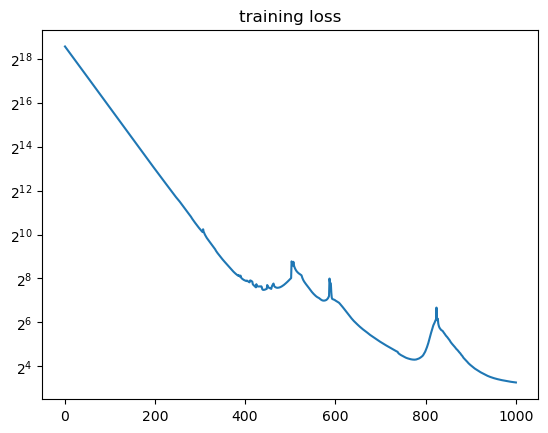

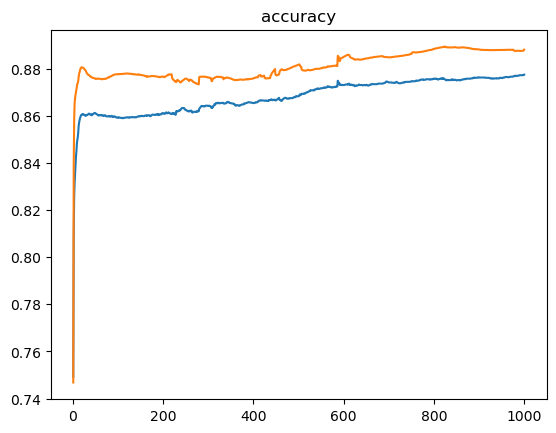

In [16]:
plt.figure()
plt.plot(np.arange(1,niter+1), loss2)
plt.yscale('log',base=2)
plt.title('training loss')

plt.figure()
plt.plot(np.arange(1,niter+1), accuracy_train)
plt.plot(np.arange(1,niter+1), accuracy_test)
plt.title('accuracy')